In [1]:
import pandas as pd
import numpy as np
import math
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=16)

# Read BT11 and Chavez14

In [2]:
# dataset available here: https://cdsarc.unistra.fr/viz-bin/cat/J/A+A/599/A76
mel17 = pd.concat([pd.read_csv('../data/cha14.csv'),
                   pd.read_csv('../data/bor11.csv')])

In [3]:
mel17.head()

,name,z,sig_5007,er_sig_5007,logLHb,er_logLHb,ewhb,er_ewhb
0,J000657,0.0737,44.8,0.43,41.30,0.01,86.5,2.1
1,J001647,0.0232,21.3,0.89,40.88,0.01,56.9,0.7
2,J002339,0.0531,30.5,0.62,41.32,0.01,110.1,1.3
3,J002425,0.0142,34.9,0.54,40.31,0.01,61.6,0.8
4,J003218,0.0180,38.6,0.49,40.34,0.01,80.0,0.9


In [4]:
mel17['sig_5007'].min()

12.7

In [5]:
mel17.shape

(132, 8)

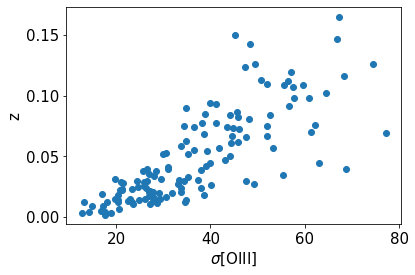

In [6]:
plt.scatter(mel17.sig_5007, mel17.z)
plt.xlabel(r'$\sigma$' '[OIII]', size=15)
plt.ylabel('z', size=15)
plt.show()

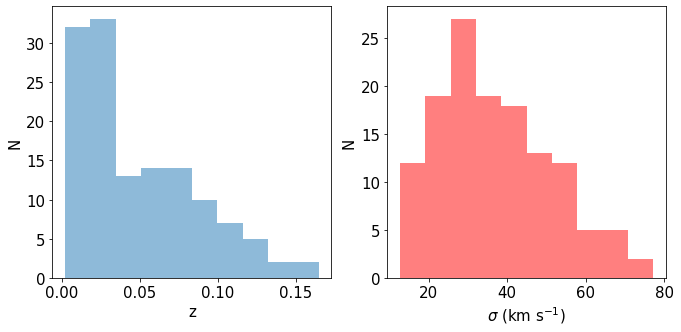

In [7]:
plt.figure(figsize=(11,5))
ax1 = plt.subplot(121)
ax1.hist(mel17.z, alpha=0.5)
ax1.set_xlabel('z', size=15)
ax1.set_ylabel('N', size=15)

ax2 = plt.subplot(122)
ax2.hist(mel17.sig_5007, alpha=0.5, color='r')
ax2.set_xlabel(r'$\sigma$ (km s$^{-1}$)', size=15)
ax2.set_ylabel('N', size=15)
plt.show()

The sample $\sigma-z$ bias was observed in Bordalo (2009) for the full sample of HIIGs (120 objects):
<img src="../data/ls118z.png" width="45%">

# Generate a synthetic $L-\sigma$ dataset

In [8]:
def mock_normal_lsigma(n_sample=45, mu=24, sig=1.45, a=3.76, b=35.26, er=0.27, plot=True, sig_cut=12.7):
    """
    This function generates a synthetic L-sigma dataset to test
    regression models.

    Input arguments:
    
    n_sample : number of data points
    mu : mean sigma for the sample in km/s
    sig : standard deviation of sigmas for the sample in km/s 
    slope : slope of the L-sigma relation
    b : intercept of the L-sigma relation
    er : rms in logL
    sig_cut : minimum sigma value in the sample (the supersonic threshold value)
    
    Default values are set with values to reproduce the properties
    for the sample of 45 HIIGs in BT11.
    """
    
    # Generates a normal distribution in log units of sigma values for the sample with
    # mean and standard deviation defined. 
    X = np.random.normal(np.log10(mu), np.log10(sig), n_sample)
    
    # Apply a sigma cut to the normal distribution previously generated to limit sythetic data for
    # objects with supersonic velocity dispersions or a specific value defined
    if sig_cut:
        X = X[X>np.log10(sig_cut)]

    X = X.reshape(-1,1)

    # Generate log L values to mimic a given power law for L-sigma
    # An specific noise amount is applied
    y = (a*X[:,0]) + b + er*np.random.randn(X.shape[0])

    if plot == True:
        reg = LinearRegression().fit(X, y)
        print('R^2: {}'.format(reg.score(X, y).round(4)))
        print('slope: {}'.format(reg.coef_[0].round(3)))
        print('intercept: {}'.format(reg.intercept_.round(3)))

        plt.figure(figsize=(13,11))

        ax1 = plt.subplot(221)
        ax1.hist(X)
        ax1.set_ylabel('N', size=15)
        ax1.set_xlabel(r'log $\sigma$ (km s$^{-1}$)', size=15)

        ax2 = plt.subplot(222)
        ax2.hist(y)
        ax2.set_ylabel('N', size=15)
        ax2.set_xlabel(r'log $L$ (erg s$^{-1}$)', size=15)

        ax3 = plt.subplot(212)
        ax3.scatter(X,y, alpha=0.3)
        ax3.set_xlabel(r'log $\sigma$ (km s$^{-1}$)', size=15)
        ax3.set_ylabel(r'log $L$ (erg s$^{-1}$)', size=15)

        Xfit = np.linspace(min(X), max(X), 100)
        yfit = reg.coef_[0]*Xfit + reg.intercept_
        ax3.plot(Xfit,yfit)

        plt.show()

R^2: 0.8128
slope: 3.832
intercept: 35.165


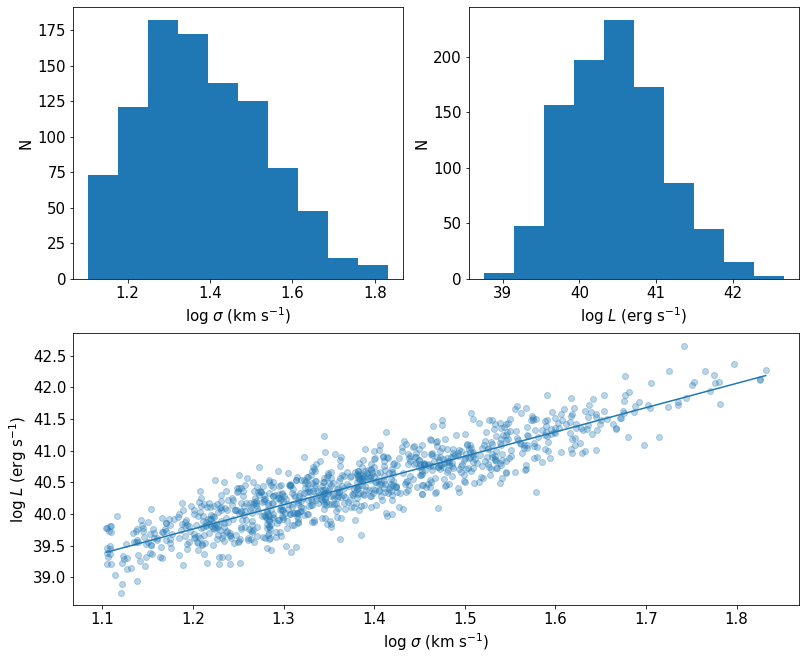

In [9]:
mock_normal_lsigma(1000)

# Create a categorical variable for the redshift bins (first idea)

In [10]:
labels = []
bins = 3
for i in range(bins):
    labels.append('z'+str(i+1))

#create a new column for the z bin
mel17['z_bin'] = pd.cut(mel17['z'], bins=bins, labels=labels)
mel17['sigz'] = mel17['sig_5007']*mel17['z']
mel17['sigz_bin'] = pd.cut(mel17['sigz'], bins=bins, labels=labels)

In [11]:
mel17.head()

,name,z,sig_5007,er_sig_5007,logLHb,er_logLHb,ewhb,er_ewhb,z_bin,sigz,sigz_bin
0,J000657,0.0737,44.8,0.43,41.30,0.01,86.5,2.1,z2,3.30176,z1
1,J001647,0.0232,21.3,0.89,40.88,0.01,56.9,0.7,z1,0.49416,z1
2,J002339,0.0531,30.5,0.62,41.32,0.01,110.1,1.3,z1,1.61955,z1
3,J002425,0.0142,34.9,0.54,40.31,0.01,61.6,0.8,z1,0.49558,z1
4,J003218,0.0180,38.6,0.49,40.34,0.01,80.0,0.9,z1,0.69480,z1


## Undersampling to remove $\sigma-Z$ bias

In [12]:
X = mel17.iloc[:,:-1].to_numpy()
print(X.shape)
y = mel17['z_bin'].to_numpy()
print(y.shape)

(132, 10)
(132,)


In [13]:
Counter(y)

Counter({'z2': 38, 'z1': 83, 'z3': 11})

In [14]:
X_res, y_res = RandomUnderSampler().fit_resample(X, y)

In [15]:
Counter(y_res)

Counter({'z1': 11, 'z2': 11, 'z3': 11})

In [16]:
log_sigma = np.log10(X_res[:,2].astype('float').reshape(-1, 1))
log_L = X_res[:,4].astype('float')

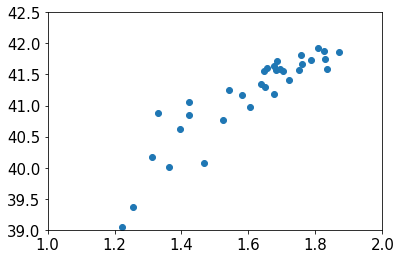

In [17]:
plt.scatter(log_sigma, log_L)
plt.xlim(1,2)
plt.ylim(39,42.5)
plt.show()

# Fit $n$ independent unbiased $L-\sigma$ relations

Where $n$ is $C(83,11) \times C(38,11)$ for 3 redshift bins!!

Estimate the coeficients ($\alpha$ and $\beta$) by convergence.

In [24]:
slopes = []
mean_slopes = []

intercepts = []
mean_intercepts = []

scores = []
mean_scores = []

for i in range(5000):
    X_res, y_res = RandomUnderSampler(random_state=i).fit_resample(X, y)
    log_sigma = np.log10(X_res[:,2].astype('float').reshape(-1, 1))

    log_L = X_res[:,4].astype('float')

    reg = LinearRegression().fit(log_sigma, log_L)
    #print('R^2: {}; slope: {}; intercept: {}'.format(reg.score(log_sigma, log_L).round(4), reg.coef_[0].round(3), reg.intercept_.round(3)))

    scores.append(reg.score(log_sigma, log_L))
    mean_scores.append(sum(scores)/len(scores))

    slopes.append(reg.coef_[0])
    mean_slopes.append(sum(slopes)/len(slopes))

    intercepts.append(reg.intercept_)
    mean_intercepts.append(sum(intercepts)/len(intercepts))


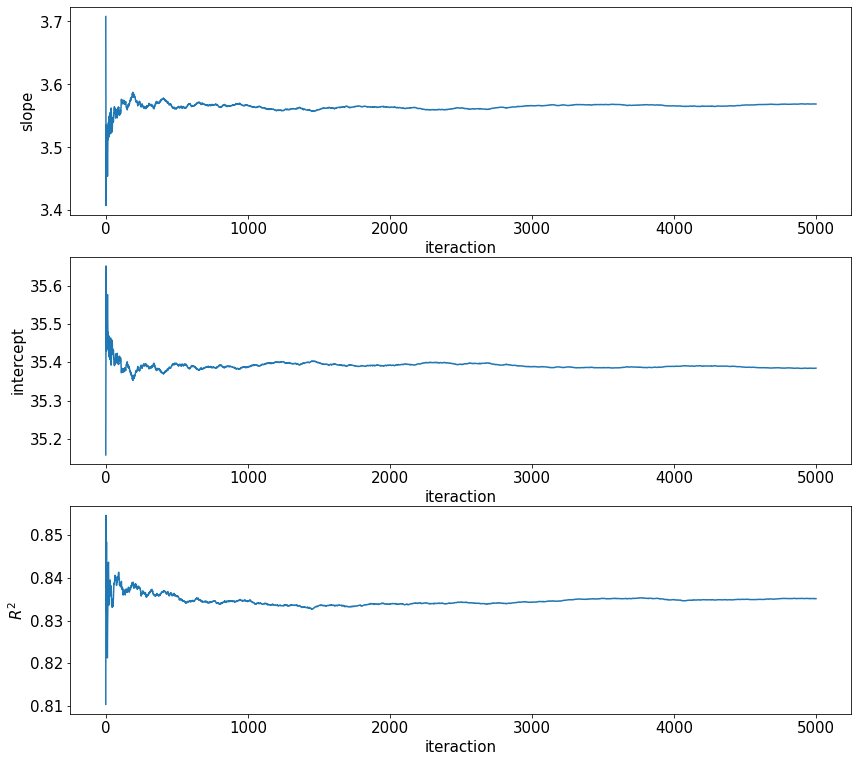

In [25]:
plt.figure(figsize=(14,13))

ax1 = plt.subplot(311)
ax1.plot(range(len(mean_slopes)), mean_slopes)
ax1.set_ylabel('slope', size=15)
ax1.set_xlabel('iteraction', size=15)
#ax1.set_ylim(3.2,3.8)

ax2 = plt.subplot(312)
ax2.plot(range(len(mean_intercepts)), mean_intercepts)
ax2.set_ylabel('intercept', size=15)
ax2.set_xlabel('iteraction', size=15)
#ax2.set_ylim(35.34,35.45)

ax3 = plt.subplot(313)
ax3.plot(range(len(mean_scores)), mean_scores)
ax3.set_ylabel(r'$R^2$', size=15)
ax3.set_xlabel('iteraction', size=15)
#ax3.set_ylim(0.825, 0.845)

plt.show()